# UsahaKu - Predictive Time Series

## Import Library

In [1]:
import numpy as np
import pandas as pd
import requests
import pickle
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.colors as m
from google.colab import drive
import matplotlib.ticker as ticker

import tensorflow as tf
from keras import layers, models, metrics
from keras.layers import Dense, LSTM, Dropout
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import load_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
print(tf.__version__)

2.18.0


In [3]:
print(sklearn.__version__)

1.6.1


## Data Loading

In [4]:
url ='https://raw.githubusercontent.com/UsahaKu-DBS/Machine-Learning/refs/heads/main/timeseries_2020_2023.csv'

df = pd.read_csv(url)
df

,Tanggal,Pemasukan,Pengeluaran,Net_Income
0,2020-01-01,533650.674272,261709.864433,271940.809839
1,2020-01-02,522646.460900,343257.251688,179389.209212
2,2020-01-03,510077.500875,278691.752404,231385.748471
3,2020-01-04,517153.004379,287106.830289,230046.174089
4,2020-01-05,476311.130499,308548.772386,167762.358113
...,...,...,...,...
1456,2023-12-27,660910.221802,298762.903246,362147.318556
1457,2023-12-28,705294.940719,346572.179452,358722.761267
1458,2023-12-29,732865.717533,334864.958148,398000.759385
1459,2023-12-30,706555.710445,316438.642727,390117.067717


## Exploratory Data Analysis

In [5]:
# Konversi kolom tanggal menjadi datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pemasukan    1461 non-null   float64
 1   Pengeluaran  1461 non-null   float64
 2   Net_Income   1461 non-null   float64
dtypes: float64(3)
memory usage: 45.7 KB


In [6]:
df.describe()

,Pemasukan,Pengeluaran,Net_Income
count,1461.000000,1461.000000,1461.000000
mean,600690.966302,298243.181237,302447.785065
std,65377.709024,49429.152473,82815.079893
min,399767.753523,107217.801428,24383.992991
25%,551590.835052,262595.110371,243832.833158
50%,599363.219182,297646.575394,302989.006083
75%,651775.397656,332276.656061,359293.524169
max,788260.048476,440971.657262,625649.887426


In [7]:
# Duplicated
df.duplicated().sum()

np.int64(0)

In [8]:
# Missing Values
df.isna().sum()

,0
Pemasukan,0
Pengeluaran,0
Net_Income,0


In [9]:
df

,Pemasukan,Pengeluaran,Net_Income
Tanggal,,,
2020-01-01,533650.674272,261709.864433,271940.809839
2020-01-02,522646.460900,343257.251688,179389.209212
2020-01-03,510077.500875,278691.752404,231385.748471
2020-01-04,517153.004379,287106.830289,230046.174089
2020-01-05,476311.130499,308548.772386,167762.358113
...,...,...,...
2023-12-27,660910.221802,298762.903246,362147.318556
2023-12-28,705294.940719,346572.179452,358722.761267
2023-12-29,732865.717533,334864.958148,398000.759385


In [10]:
def plot(data):
  plt.plot(data['Pemasukan'], label = 'Pemasukan', color = 'tab:blue')
  plt.plot(data['Pengeluaran'], label = 'Pengeluaran', color = 'tab:red')
  plt.show()

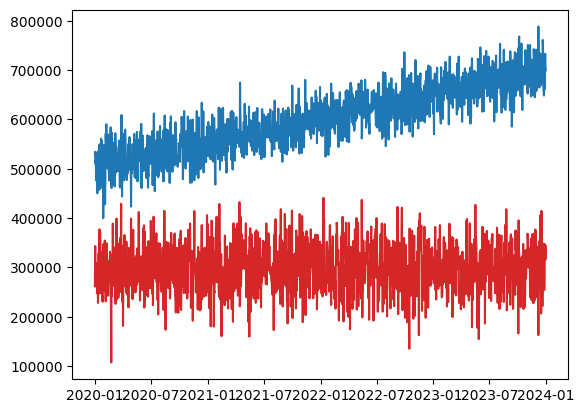

In [11]:
plot(df)

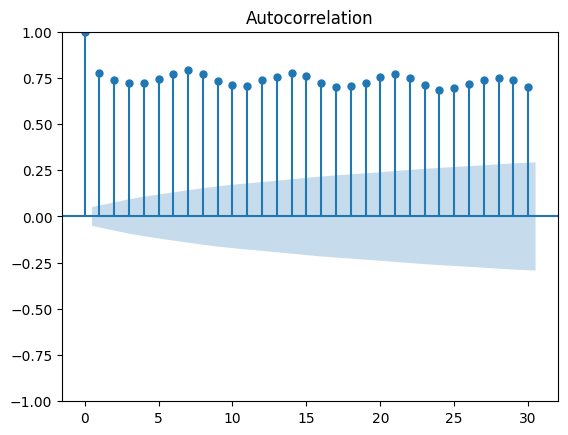

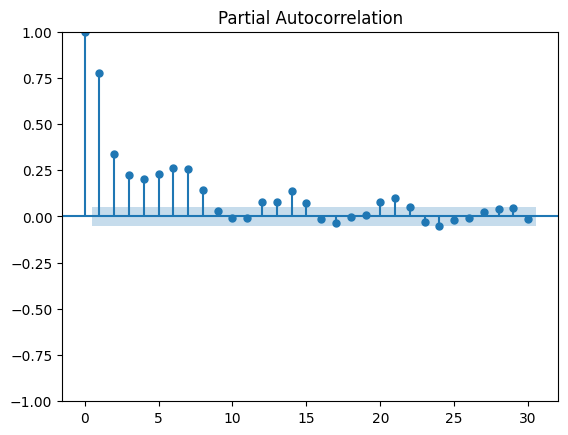

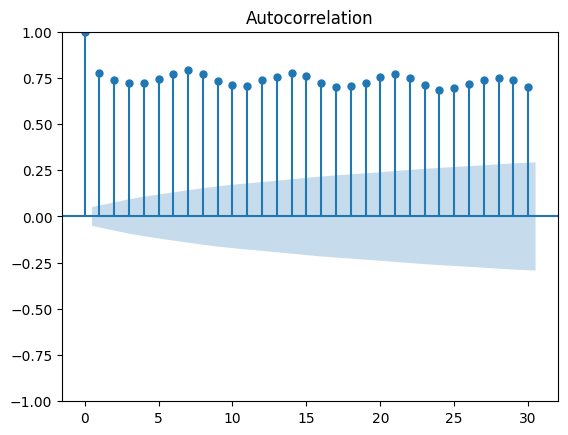

In [12]:
# pacf and acf plots
lag = 30
window = 8
plot_pacf(df['Pemasukan'], lags=lag)
plot_acf(df['Pemasukan'], lags=lag)

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Pemasukan'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("stationary.")
else:
    print("non-stationary")


ADF Statistic: -0.7643665955643046
p-value: 0.8293657318726213
non-stationary


In [14]:
diff_pemasukan = df['Pemasukan'].diff().dropna()
result = adfuller(diff_pemasukan)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("stationary.")
else:
    print("non-stationary")


ADF Statistic: -16.931562378716368
p-value: 9.76817423561865e-30
stationary.


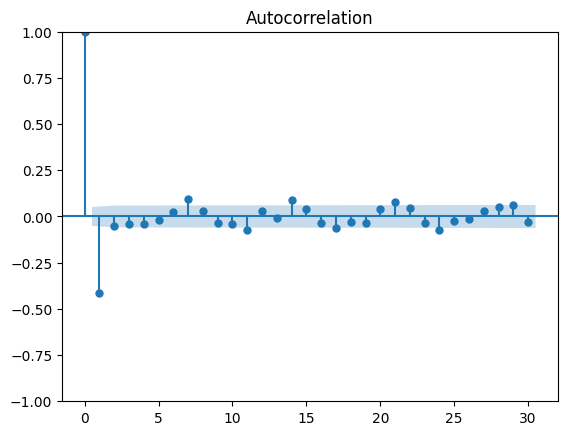

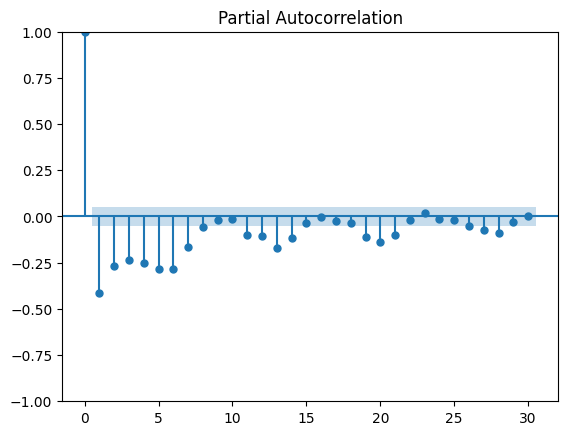

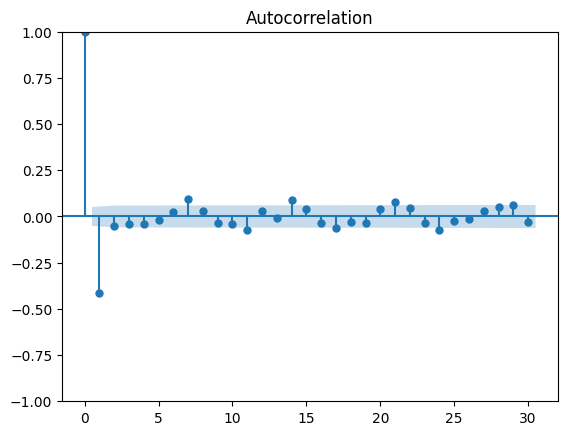

In [15]:
# pacf and acf plots
lag = 30
window = 8
plot_pacf(diff_pemasukan, lags=lag)
plot_acf(diff_pemasukan, lags=lag)

## Data Preprocessing

In [16]:
# sliding window

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [17]:
x, y = create_sequences(df['Pemasukan'], window)

<ipython-input-16-73b0474161cc>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + window_size])


In [18]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y = y.reshape(-1,1)

x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

print(x_scaled.shape)
print(y_scaled.shape)

(1453, 8)
(1453, 1)


In [19]:
# Simpan hasil standarisasi menggunakan pickle
pickle.dump(x_scaled, open('x_scaled.pkl','wb'))
pickle.dump(y_scaled, open('y_scaled.pkl','wb'))

# Simpan objek scaler yang sudah fit
pickle.dump(scaler_x, open('scaler_x.pkl','wb'))
pickle.dump(scaler_y, open('scaler_y.pkl','wb'))

In [20]:
# Ubah 3 dimensi
x_scaled = x_scaled.reshape((x_scaled.shape[0], x_scaled.shape[1], 1))

# Split
X , x_test, Y, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, shuffle=False)


print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1176, 8, 1) (1176, 1)
(131, 8, 1) (131, 1)
(146, 8, 1) (146, 1)


## Modelling

In [21]:
def build_model(window):
  model = Sequential([
    layers.LSTM(128, input_shape=(window,1), return_sequences = True),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(1)
  ])
  return model

In [22]:
model = build_model(lag)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Callback
early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

# Simpan model terbaik
model_checkpoint = ModelCheckpoint(
    filepath='model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [24]:
model.compile(loss=MeanSquaredError(), optimizer='adam', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3991 - mae: 0.5030
Epoch 1: val_loss improved from inf to 0.24578, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.3948 - mae: 0.5003 - val_loss: 0.2458 - val_mae: 0.4085
Epoch 2/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2665 - mae: 0.4147
Epoch 2: val_loss improved from 0.24578 to 0.24577, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2665 - mae: 0.4148 - val_loss: 0.2458 - val_mae: 0.4083
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2683 - mae: 0.4120
Epoch 3: val_loss did not improve from 0.24577
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2682 - mae: 0.4119 - val_loss: 0.2577 - val_mae: 0.4183
Epoch 4/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2771 - mae: 0.4276
Epoch 4: val_loss did not improve from 0.24577
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2767 - mae: 0.4271 - val_loss: 0.2941 - val_mae: 0.4453
Epoch 5/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2676 - mae: 0.4156
Epoch 5: val_loss improved from 0.24577 to 0.24371, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2678 - mae: 0.4158 - val_loss: 0.2437 - val_mae: 0.3974
Epoch 6/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2490 - mae: 0.3984
Epoch 6: val_loss did not improve from 0.24371
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2504 - mae: 0.3995 - val_loss: 0.2454 - val_mae: 0.4070
Epoch 7/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2725 - mae: 0.4187
Epoch 7: val_loss improved from 0.24371 to 0.23381, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2720 - mae: 0.4182 - val_loss: 0.2338 - val_mae: 0.3961
Epoch 8/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2632 - mae: 0.4122
Epoch 8: val_loss did not improve from 0.23381
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2638 - mae: 0.4128 - val_loss: 0.2489 - val_mae: 0.4101
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2741 - mae: 0.4146
Epoch 9: val_loss did not improve from 0.23381
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2739 - mae: 0.4145 - val_loss: 0.2569 - val_mae: 0.4170
Epoch 10/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2642 - mae: 0.4154
Epoch 10: val_loss did not improve from 0.23381
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2641 - mae: 0.4151 - val_loss: 0.2655 - val_mae: 0.4233
Epoch 11/50
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2644 - mae: 0.4165
Epoch 11: val_loss did not improve from 0.23381
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2645 - mae: 0.

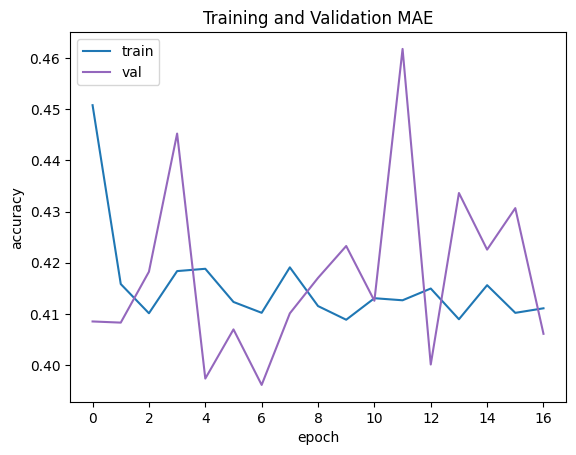

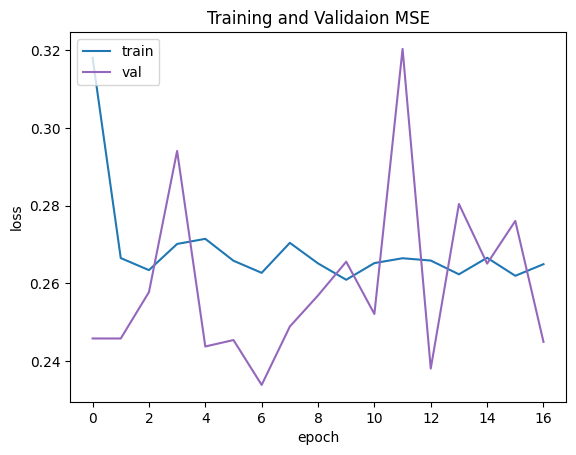

In [25]:
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'tab:blue')
plt.plot(epochs, val_acc, 'tab:purple')
plt.title('Training and Validation MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'tab:blue')
plt.plot(epochs, val_loss, 'tab:purple')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion MSE')
plt.show()

In [26]:
# eval
model.evaluate(x_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3001 - mae: 0.4509


[0.2818162143230438, 0.43262210488319397]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
(146, 1)
(146, 1)


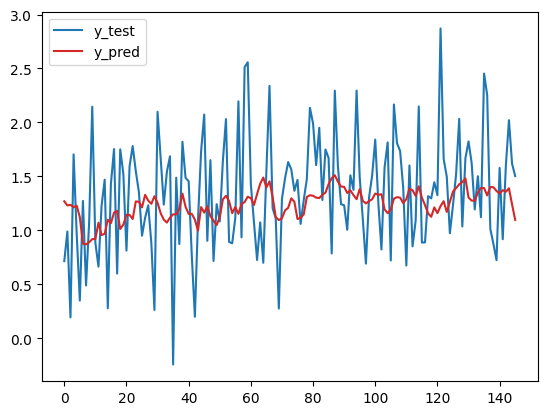

In [27]:
y_pred = model.predict(x_test)
print(y_pred.shape)
print(y_test.shape)

y_test_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

min_len = min(len(y_test_flat), len(y_pred_flat))
y_test_flat = y_test_flat[:min_len]
y_pred_flat = y_pred_flat[:min_len]

plt.plot(y_test_flat, label='y_test', color='tab:blue')
plt.plot(y_pred_flat, label='y_pred', color='tab:red')
plt.legend()
plt.show()


# Inferences

In [28]:
def inference_lstm_latest(model_path, scaler_x_path, scaler_y_path, x_scaled_path, window):
    # Load model dan scaler
    model = load_model(model_path)
    scaler_x = pickle.load(open(scaler_x_path, 'rb'))
    scaler_y = pickle.load(open(scaler_y_path, 'rb'))

    # Load data x_scaled yang sudah disimpan (bukan scaler)
    x_scaled_all = pickle.load(open(x_scaled_path, 'rb'))

    # Pastikan data x_scaled_all 2D dan reshape jadi 1 fitur
    x_scaled_all = x_scaled_all.reshape(-1, 1)

    # Ambil data terakhir sebanyak 'window'
    if len(x_scaled_all) < window:
        raise ValueError(f"Data tidak cukup panjang, butuh minimal {window} baris")
    x_latest = x_scaled_all[-window:]

    # Bentuk input untuk LSTM: (1, window, 1)
    x_latest = x_latest.reshape(1, window, 1)

    # Prediksi output diskalakan
    y_pred_scaled = model.predict(x_latest)

    # Inverse transform hasil prediksi ke skala asli
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    return y_pred.flatten()[0]

# Contoh penggunaan
prediksi_terbaru = inference_lstm_latest(
    model_path='model.h5',
    scaler_x_path='scaler_x.pkl',
    scaler_y_path='scaler_y.pkl',
    x_scaled_path='x_scaled.pkl',
    window=8
)

print(f"Prediksi nilai pemasukan selanjutnya: {prediksi_terbaru:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Prediksi nilai pemasukan selanjutnya: 672601.12
